# CS M148 Project - Linear Regression, LDA, QDA

This notebook consists of the algorithms logistic regression, linear discriminant analysis, and quadratic discriminant analysis. The table of contents is given below: 
- Data Preprocessing and EDA
- Model Fitting
- Model Tuning 
- Evaluating Model Performances

## Loading in Data and Packages

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/justingong/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv("water_potability.csv", sep=",")

In [7]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


The data has been successly loaded in! We may now proceeed to proceed to preprocess the data to be appropriate for model fitting

## Data Preprocessing and EDA

In [14]:
print("Dataframe Dimensions: ", df.shape)

Dataframe Dimensions:  (3276, 10)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


This dataset has 3276 observations with 9 features, all of which are numerical. The data types of the variables are appropriate for model fitting and does not require transformations.

Let's now observe the distribution of our categorical variable, Potability:

Text(0, 0.5, 'Count')

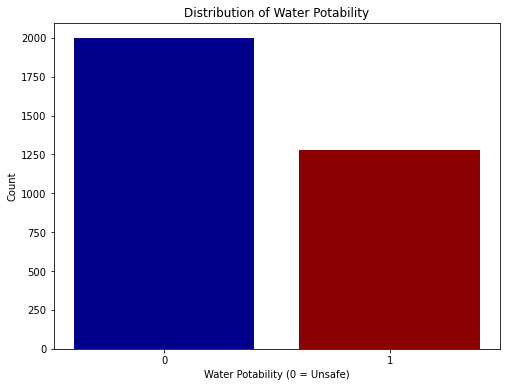

In [51]:
value_counts = df['Potability'].value_counts()
plt.figure(figsize = (8, 6))
plt.bar([str(x) for x in value_counts.index], value_counts.values, color = ['darkblue', 'darkred'])
plt.title("Distribution of Water Potability")
plt.xlabel("Water Potability (0 = Unsafe)")
plt.ylabel("Count")

In [54]:
(df['Potability'] == 0).mean().round(2)

0.61

Approximately **61%** of the dataset is unsafe water

In [55]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

According to the information above, there are 3 features that have missing values. In the event that these are all unique observations (Unlikely), this would total to over 1000 observations. Therefore, it would not be ideal to simply drop the observations with missing values as this is a large portion of our data. 

In [23]:
df['Potability'][df['ph'].isna()].value_counts()

Potability
0    314
1    177
Name: count, dtype: int64

In [25]:
df['Potability'][df['Sulfate'].isna()].value_counts()

Potability
0    488
1    293
Name: count, dtype: int64

In [24]:
df['Potability'][df['Trihalomethanes'].isna()].value_counts()

Potability
0    107
1     55
Name: count, dtype: int64

Since there are only 162 missing trihalomethanes values and there does not seem to have any meaningful information from the NA values (The distribution of the potability is approximately the same as the full dataset), then we may drop these rows:

In [4]:
df.dropna(subset = ["Trihalomethanes"], axis = 0, inplace = True)
df.shape

(3114, 10)

Since there are a large number of missing values for sulfate and ph, we will use the median from the existing values in order to impute the missing values.

In [5]:
df['Sulfate'].fillna(df['Sulfate'].median(), inplace = True)
df['ph'].fillna(df['ph'].median(), inplace = True)

In [6]:
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [99]:
df.columns[0:10]

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

We have now removed all missing values from the dataset, now we may proceed with analyzing the distribution of the data and check for outliers

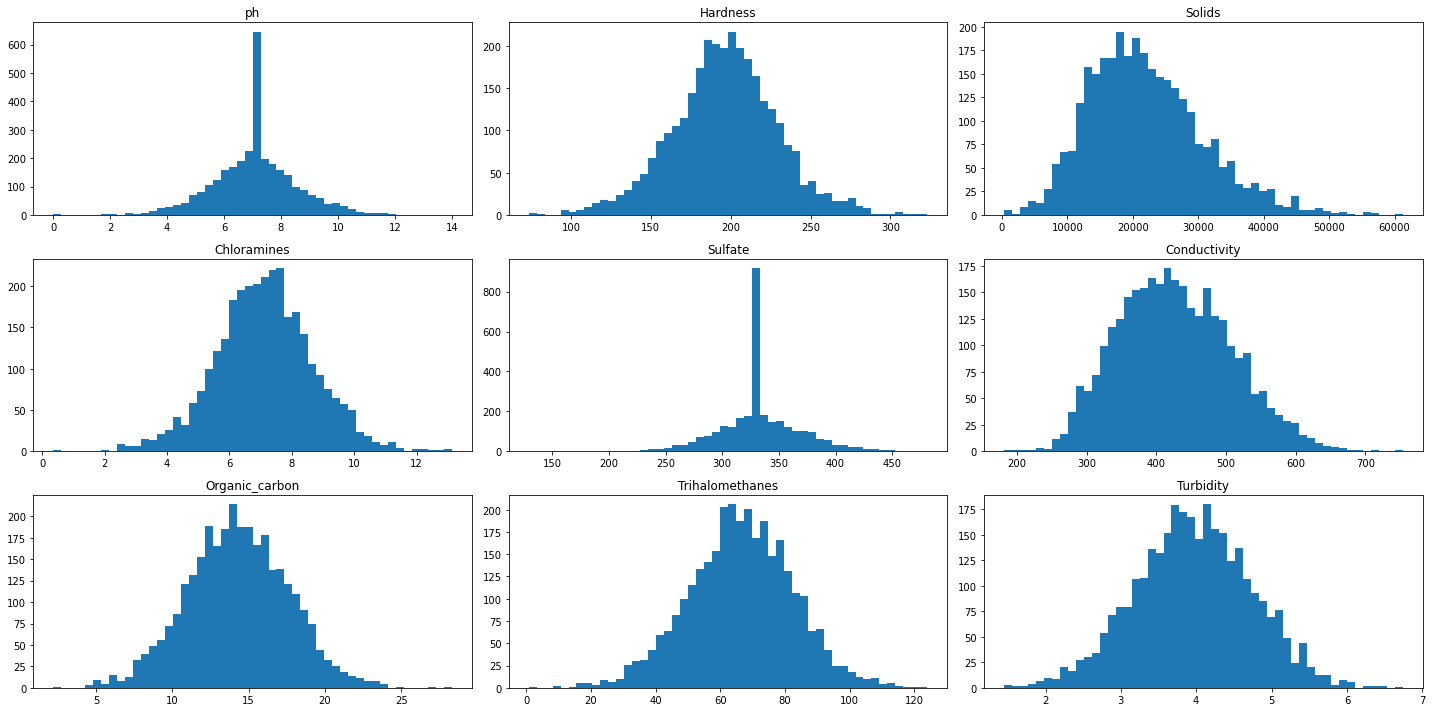

In [120]:
plt.figure(figsize = (20, 10))
for i, colname in enumerate(df.columns[0:9]): 
    plt.subplot(3,3,(i + 1))
    plt.hist(df[colname], bins = 50)
    plt.title(colname)
plt.tight_layout()
plt.show()

It is clear that each of the numerical columns are normally distributed, which makes linear regression is a great choice for fitting to this data. Additionally, there is likely no need to remove outliers due to the normal distribution of the data. 

Let's now divide the data into training and testing datasets (Will perform cross validation so no validation dataset is necessary).

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:9], df['Potability'], test_size=0.3, random_state=42)

## Logistic Regression

Now we will fit a logistic regression model. Before doing so, let's check for multicollinearity in our model. This will determine whether or not feature selection is important. 

<AxesSubplot:>

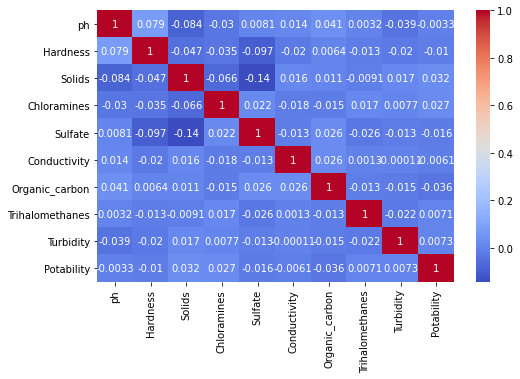

In [126]:
plt.figure(figsize = (8, 5))
sns.heatmap(df.corr(), annot=True, cmap = 'coolwarm')

It appears that none of the variables are multicollinearity, so we do not have to worry about dropping features (for now). Let's now fit the logistic regression model:

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

log_model = LogisticRegression() 
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [163]:
print("Accuracy:", sum(y_test == log_model.predict(X_test_scaled)) / len(y_test))

Accuracy: 0.6288770053475936


The accuracy of the logistic regression model is 0.628877. Let's observe other evaluation metrics to see it's performance.

In [167]:
print("Training Accuracy:", sum(y_train == log_model.predict(X_train_scaled)) / len(y_train))

Training Accuracy: 0.5993575034419458


Since the training accuracy is less than the testing accuracy, I do not suspect overfitting to be a major issue, but I will still test for Ridge and Lasso regression. Now let's explore the cross validated accuracy rate.

In [184]:
from sklearn.model_selection import cross_val_score
print("Cross-Validated Accuracy:", cross_val_score(log_model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean())

Cross-Validated Accuracy: 0.5961446799536011


Text(33.0, 0.5, 'Predicted Label')

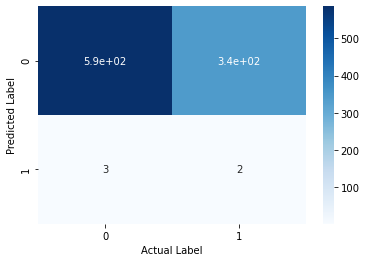

In [174]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(log_model.predict(X_test_scaled), y_test), annot=True, cmap = 'Blues')
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

From the confusion matrix, it appears that a big problem with the model is that it is not predicting enough successes (Potable water). Therefore, the accuracy is misleading because it is mainly predicting the majority of the labels to be 0. The sensitivity is 0.9949, which is very good, but the specificity is 0.00578 which is very poor. Therefore, we are aiming to decrease this specificity rate. Let's explore to see how Ridge and Lasso regression performs.

## Ridge and Lasso Regression

We will now explore if Ridge and Lasso regression improves the accuracy compared to logistic regression. Let's first perform Ridge regression:

In [215]:
from sklearn.linear_model import LassoCV, RidgeCV

alpha_values = [0.01, 0.1, 1, 10, 50, 100, 150, 200, 250, 300]
ridge_model = RidgeCV(alpha_values, store_cv_values = True)
ridge_model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.0e-02, 1.0e-01, 1.0e+00, 1.0e+01, 5.0e+01, 1.0e+02, 1.5e+02,
       2.0e+02, 2.5e+02, 3.0e+02]),
        store_cv_values=True)

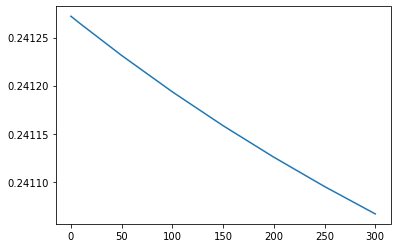

In [216]:
plt.plot(alpha_values, ridge_model.cv_values_.mean(axis = 0)) 

It appears that the best alpha value for Ridge continues to increase, therefore we will proceed with 300. 

In [232]:
print("Testing Accuracy:", (y_test == (ridge_model.predict(X_test_scaled) > 0.5).astype(int)).mean())

Testing Accuracy: 0.627807486631016


Text(33.0, 0.5, 'Predicted Label')

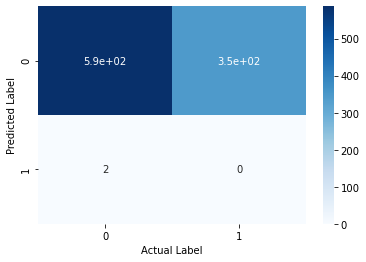

In [246]:
sns.heatmap(confusion_matrix((ridge_model.predict(X_test_scaled) > 0.5).astype(int), y_test), annot=True, cmap = 'Blues')
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

Ridge regression still results in the same error as previously discovered with logistic regression in that there's not enough predictions for potable water. Let's try adjusting the threshold to see if there's an impact in the results. 

In [272]:
print("Testing Accuracy:", (y_test == (ridge_model.predict(X_test_scaled) > 0.40).astype(int)).mean())

Testing Accuracy: 0.5026737967914439


Text(33.0, 0.5, 'Predicted Label')

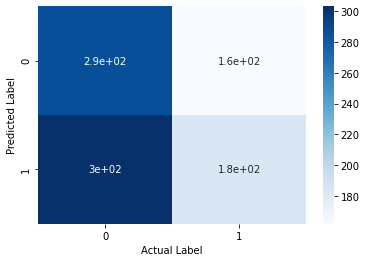

In [273]:
sns.heatmap(confusion_matrix((ridge_model.predict(X_test_scaled) > 0.4).astype(int), y_test), annot=True, cmap = 'Blues')
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

Now let's attempt lasso regression:

In [261]:
lasso_model = Lasso(alpha = 0.01)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.01)

In [262]:
lasso_model.coef_

array([-0.00237327,  0.00870545,  0.        , -0.        ,  0.        ,
       -0.01091853, -0.        ,  0.00409177])

In [280]:
print("Testing Accuracy:", (y_test == (lasso_model.predict(X_test_scaled) > 0.5).astype(int)).mean())

Testing Accuracy: 0.6299465240641712


Text(33.0, 0.5, 'Predicted Label')

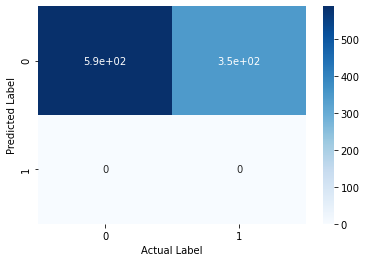

In [281]:
sns.heatmap(confusion_matrix((lasso_model.predict(X_test_scaled) > 0.5).astype(int), y_test), annot=True, cmap = 'Blues')
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")

It is clear that logistic regression, even with regularization, is not a great model in predicting classes in this case. This is probably because the data is not linearly separable, so a more complex model that can make more specific decision making is more appropriate. Let's attempt an LDA or QDA model to see if that improves accuracy. 

## LDA & QDA Model

In [282]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [283]:
lda_model = LinearDiscriminantAnalysis() 
qda_model = LinearDiscriminantAnalysis() 

lda_model.fit(X_train_scaled, y_train)
qda_model.fit(X_train_scaled, y_train) 

LinearDiscriminantAnalysis()

In [290]:
print("LDA Accuracy:", sum(y_test == lda_model.predict(X_test_scaled)) / len(y_test))
print("QDA Accuracy:", sum(y_test == qda_model.predict(X_test_scaled)) / len(y_test))

LDA Accuracy: 0.6288770053475936
QDA Accuracy: 0.6288770053475936


It appears that both QDA and LDA have the exact same accuracy, meaning that the decision boundary between the two classes are not necessarily linear nor quadratic. From this information, I suspect that the two classes are not well separated and are meshed together. Therefore, a more complex model such as 

## Dimensionality Reduction to Observe Class Separability

In [18]:
{0: 'red', 1: 'blue'}[1]

'blue'

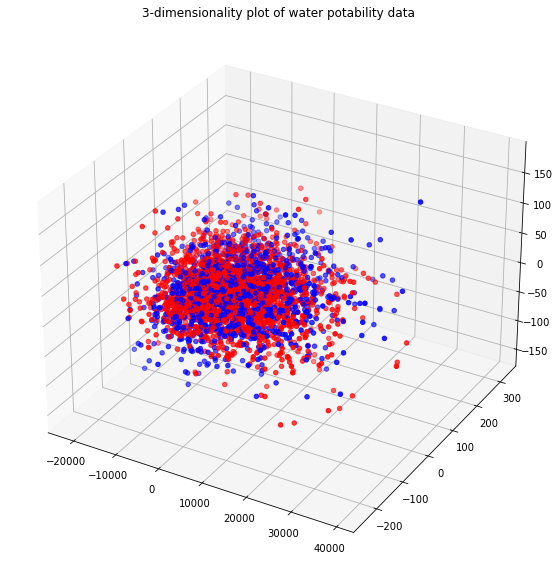

In [31]:
from sklearn.decomposition import PCA 

pca_model = PCA(n_components = 3)
pc = pca_model.fit_transform(df.iloc[:, 0:9]) 
pc_df = pd.DataFrame(pc, columns = ['PC 1', 'PC 2', 'PC 3'])

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'r', 1: 'b'}  # Change colors as needed
ax.scatter(pc_df['PC 1'], pc_df['PC 2'], pc_df['PC 3'], c = df['Potability'].apply(lambda x: {0: 'red', 1: 'blue'}[x]))
plt.title('3-dimensionality plot of water potability data')
plt.show()

In [14]:
df.iloc[:, 0:9]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.038092,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,332.890382,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,332.890382,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075
...,...,...,...,...,...,...,...,...,...
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821
3273,9.419510,175.762646,33155.578218,7.350233,332.890382,432.044783,11.039070,69.845400,3.298875
3274,5.126763,230.603758,11983.869376,6.303357,332.890382,402.883113,11.168946,77.488213,4.708658
